In [1]:
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint
import torch.optim as optim
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We'll create a fake ODE

$$\frac{dy}{dt} = Ky\sin(t/10)$$

where $K$ is an anti-symmetric matrix filled with random variables, and $y$ is a vector

In [2]:
def dydt(t, y, K):
    K_reshaped = K.unsqueeze(0).repeat(y.shape[0],1,1)
    y_reshaped = y.unsqueeze(-1)
    return torch.bmm(K_reshaped, y_reshaped).squeeze() * torch.sin(t/10)

# Part 1: Generate Fake Data

In [3]:
M = 3
realizations = 500

In [4]:
y0 = torch.rand((realizations,M)).to(device) + 1
K = torch.rand((M,M)).to(device)
K = K-K.T #antisymmetric
t_eval = torch.linspace(0, 50, 100).to(device)

In [5]:
true_sol = odeint(lambda t, y: dydt(t, y, K), y0, t_eval)

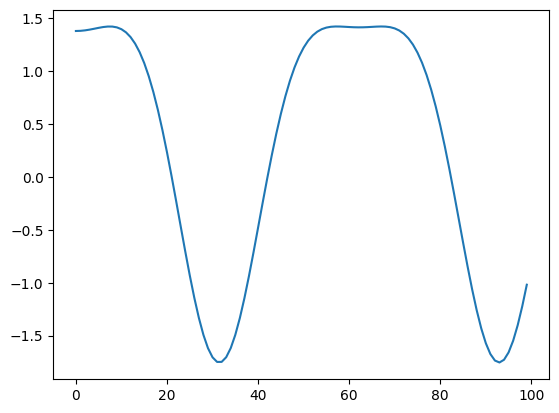

In [6]:
plt.plot(true_sol[:,0,1].cpu())

Question: How do we model the differential equation? One solution is to use a neural network.

In [7]:
class ODEFunc(nn.Module):
    def __init__(self, K_init):
        super(ODEFunc, self).__init__()
        self.register_parameter(name='K', param=torch.nn.Parameter(torch.clone(K_init)))

    def forward(self, t, y):
        K_reshaped = self.K.unsqueeze(0).repeat(y.shape[0],1,1)
        y_reshaped = y.unsqueeze(-1)
        return torch.bmm(K_reshaped, y_reshaped).squeeze() * torch.sin(t/10)

In [8]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(M, 50),
            nn.Tanh(),
            nn.Linear(50, M),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)* torch.sin(t/10)

In [9]:
ode_net = ODEFunc().to(device)
sol_init = odeint(ode_net, y0, t_eval, rtol=1e-4)

In [10]:
losses = []
optimizer = optim.RMSprop(ode_net.parameters(), lr=1e-3)
for i in range(1000):
    optimizer.zero_grad()
    sol = odeint(ode_net, y0, t_eval, rtol=1e-5)
    loss = torch.mean((sol - true_sol)**2)
    if i%10==0:
        print(loss.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

2.066499948501587
0.9974384307861328
0.9238017797470093
0.8724985122680664
0.8115723133087158
0.7043266892433167
0.303153395652771
0.06921268999576569
0.021994255483150482
0.01514032669365406
0.018982121720910072
0.014884088188409805
0.010739265009760857
0.010983402840793133
0.012242826633155346
0.011134389787912369
0.01017578411847353
0.010465758852660656
0.010803505778312683
0.01050400361418724
0.010290183126926422
0.010436548851430416
0.010575518012046814
0.010586830787360668
0.010080342181026936
0.0075950114987790585
0.00817712489515543
0.02464037388563156
0.005855581723153591
0.0050002457574009895
0.010305887088179588
0.019028477370738983
0.0075122760608792305
0.007046027109026909
0.012045346200466156
0.014096313156187534
0.0060010040178895
0.006061878055334091
0.022581102326512337
0.00992836058139801
0.006026870105415583
0.010336398147046566
0.00819091871380806
0.007839582860469818
0.016069432720541954
0.00939706340432167
0.012815029360353947
0.005805249325931072
0.01062842179089

KeyboardInterrupt: 

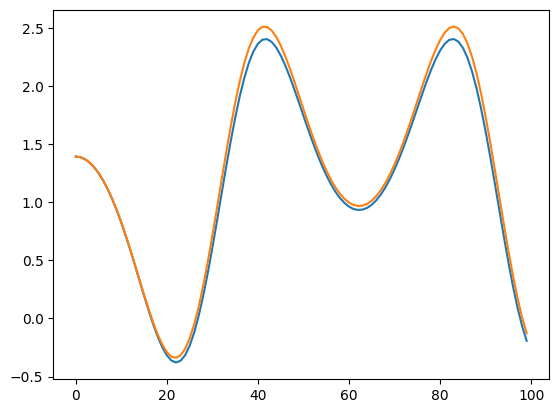

In [11]:
plt.plot(true_sol[:,0,2].cpu())
plt.plot(sol[:,0,2].cpu().detach())
plt.show()

In [12]:
K

tensor([[ 0.0000,  0.1606,  0.0263],
        [-0.1606,  0.0000,  0.2881],
        [-0.0263, -0.2881,  0.0000]], device='cuda:0')